# Lab5C Run QNN on PYNQ board
## Extract our deploy pack

In [2]:
! unzip -n deploy.zip -d ./
! cp -a deploy/driver/. .
! pip install deploy/dep/bitarray-3.4.0-cp310-cp310-linux_armv7l.whl
! pip install deploy/dep/bitstring-4.3.1-py3-none-any.whl


Archive:  deploy.zip
Processing ./deploy/dep/bitarray-3.4.0-cp310-cp310-linux_armv7l.whl
bitarray is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing ./deploy/dep/bitstring-4.3.1-py3-none-any.whl
bitstring is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


## Latency and throughput measurement

In [3]:
import numpy as np
from driver_base import FINNExampleOverlay
from qonnx.core.datatype import DataType
from pynq.pl_server.device import Device
import os

In [4]:
bitfile = "deploy/bitfile/bitfile_b3f1k/finn-accel.bit"
platform = "zynq-iodma"
io_shape_dict = {
    # FINN DataType for input and output tensors
    "idt" : [DataType['INT8']],
    "odt" : [DataType['INT16']],
    # shapes for input and output tensors (NHWC layout)
    "ishape_normal" : [(1, 490)],
    "oshape_normal" : [(1, 12)],
    # folded / packed shapes below depend on idt/odt and input/output
    # PE/SIMD parallelization settings -- these are calculated by the
    # FINN compiler.
    "ishape_folded" : [(1, 245, 2)],
    "oshape_folded" : [(1, 12, 1)],
    "ishape_packed" : [(1, 245, 2)],
    "oshape_packed" : [(1, 12, 2)],
    "input_dma_name" : ['idma0'],
    "output_dma_name" : ['odma0'],
    "number_of_external_weights": 0,
    "num_inputs" : 1,
    "num_outputs" : 1,
}
batch_size = 1
runtime_weight_dir = "runtime_weights/"
devID = 0
device = Device.devices[devID]
# instantiate FINN accelerator driver and pass batchsize and bitfile
accel = FINNExampleOverlay(
    bitfile_name = bitfile, platform = platform,
    io_shape_dict = io_shape_dict, batch_size = batch_size,
    runtime_weight_dir = runtime_weight_dir, device=device
)
res = accel.throughput_test()
print(res)

{'runtime[ms]': 2.398967742919922, 'throughput[images/s]': 416.8459550785132, 'DRAM_in_bandwidth[MB/s]': 0.20425451798847147, 'DRAM_out_bandwidth[MB/s]': 0.010004302921884317, 'fclk[mhz]': 100.0, 'batch_size': 1, 'fold_input[ms]': 0.08916854858398438, 'pack_input[ms]': 0.07486343383789062, 'copy_input_data_to_device[ms]': 0.4093647003173828, 'copy_output_data_from_device[ms]': 0.2372264862060547, 'unpack_output[ms]': 7.731437683105469, 'unfold_output[ms]': 0.049591064453125}


In [5]:
# Following the code, estimate the latency and throughput of remain 3 accs
# Compare them with the report, comment.
# ----
# YOUR CODE HERE
# ----

## Acc test

In [6]:
# load val data from the dep pack
# input_npy = "deploy/dataset/python_speech_preprocessing_all_validation_KWS_data_inputs_len_10102.npy"
# golden_out_npy = "deploy/dataset/python_speech_preprocessing_all_validation_KWS_data_outputs_len_10102.npy"
input_npy = "deploy/dataset/google_speech_X_test.npy"
golden_out_npy = "deploy/dataset/google_speech_y_test.npy"


input_data = np.load(input_npy)
golden_out_data = np.load(golden_out_npy)
num_samples = input_data.shape[0]

print("Input data shape: " + str(input_data.shape))
print("Label shape: " + str(golden_out_data.shape))
print("Number of samples:  " + str(num_samples))

Input data shape: (4874, 490)
Label shape: (4874,)
Number of samples:  4874


In [7]:
bitfile = "deploy/bitfile/bitfile_b4f100k/finn-accel.bit"
platform = "zynq-iodma"
io_shape_dict = {
    # FINN DataType for input and output tensors
    "idt" : [DataType['INT8']],
    "odt" : [DataType['UINT8']],
    # shapes for input and output tensors (NHWC layout)
    "ishape_normal" : [(1, 490)],
    "oshape_normal" : [(1, 1)],
    # folded / packed shapes below depend on idt/odt and input/output
    # PE/SIMD parallelization settings -- these are calculated by the
    # FINN compiler.
    "ishape_folded" : [(1, 245, 2)],
    "oshape_folded" : [(1, 1, 1)],
    "ishape_packed" : [(1, 245, 2)],
    "oshape_packed" : [(1, 1, 1)],
    "input_dma_name" : ['idma0'],
    "output_dma_name" : ['odma0'],
    "number_of_external_weights": 0,
    "num_inputs" : 1,
    "num_outputs" : 1,
}
batch_size = num_samples
runtime_weight_dir = "runtime_weights/"
devID = 0
device = Device.devices[devID]
# instantiate FINN accelerator driver and pass batchsize and bitfile
accel = FINNExampleOverlay(
    bitfile_name = bitfile, platform = platform,
    io_shape_dict = io_shape_dict, batch_size = batch_size,
    runtime_weight_dir = runtime_weight_dir, device=device
)

In [8]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal()), str(accel.idt())))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal()), str(accel.odt())))

Expected input shape and datatype: (4874, 490) INT8
Expected output shape and datatype: (4874, 1) UINT8


In [9]:
accel.batch_size = num_samples
accel_out_data = accel.execute(input_data)

print("Accelerator output shape: " + str(accel_out_data.shape))

Accelerator output shape: (4874, 1)


In [10]:
score = np.unique(accel_out_data.flatten() == golden_out_data.flatten(), return_counts=True)
print("Correctly predicted: %d / %d " % (score[1][1], num_samples))
print("Incorrectly predicted: %d / %d " % (score[1][0], num_samples))
print("Accuracy: %f%%" % (100.0 * score[1][1] / num_samples))

Correctly predicted: 3835 / 4874 
Incorrectly predicted: 1039 / 4874 
Accuracy: 78.682807%


In [11]:
# Following the code, benchmark the accuracy of other 3 accs
# ----
# YOUR CODE HERE
# ----

## E2E: Classfiy .wav files


In [12]:
from deploy.dep.mfcc_lib import mfcc
import numpy as np
from scipy import signal
import scipy.io.wavfile as wav
from scipy.signal.windows import hann
import matplotlib.pyplot as plt
import IPython

Matplotlib is building the font cache; this may take a moment.


In [13]:
# preprocessing parameters
tf_desired_samples = 16000
tf_window_size_samples = 480
tf_sample_rate = 16000
tf_window_size_ms = 30.
tf_window_stride_ms = 20.
tf_dct_coefficient_count = 10

# Dataset parameter
tf_dataset_labels = [
    "yes", "no", "up", "down", "left",
    "right", "on", "off", "stop", "go",
    "silence", "unknown",
]

In [14]:
# Convenience functions
def py_speech_preprocessing(resampled_data, sample_rate,
                            tf_desired_samples=tf_desired_samples, 
                            tf_window_size_samples=tf_window_size_samples, 
                            tf_sample_rate=tf_sample_rate, 
                            tf_window_size_ms=tf_window_size_ms, 
                            tf_dct_coefficient_count=tf_dct_coefficient_count):
    # Resample
    num_target_samples = round(tf_sample_rate / sample_rate * len(raw_signal))
    resampled_data = signal.resample(raw_signal, num_target_samples)
    # Rescale
    rescaled_data = resampled_data / np.max(resampled_data)
    # Pad
    padded_data = np.pad(rescaled_data, [[0, tf_desired_samples - rescaled_data.shape[-1]]], mode="constant")
    # Calculate MFCC features
    nfft = int(2**np.ceil(np.log2(tf_window_size_samples)))
    mfcc_feat_py = mfcc(padded_data, tf_sample_rate, 
                     winlen = tf_window_size_ms / 1000.,
                     winstep = tf_window_stride_ms / 1000.,
                     numcep = tf_dct_coefficient_count,
                     nfilt = 40,
                     nfft = nfft,
                     lowfreq = 20.0,
                     highfreq = 4000.0,
                     winfunc=hann,
                     appendEnergy=False,
                     preemph=0.,
                     ceplifter=0.,
                    )
    # Cut and transpose MFCC features
    mfcc_feat_py = mfcc_feat_py[:-1,:].T
    
    return mfcc_feat_py


def quantize_input(mfcc_feat_py):
    # Scaling
    quant_mfcc_feat = (mfcc_feat_py / 0.8298503756523132)
    # Clamping & rounding
    quant_mfcc_feat = np.where(quant_mfcc_feat > 127., 127., quant_mfcc_feat)
    quant_mfcc_feat = np.where(quant_mfcc_feat < -127., -127., quant_mfcc_feat)
    quant_mfcc_feat = np.round(quant_mfcc_feat)
    quant_mfcc_feat = quant_mfcc_feat.astype(np.int8).reshape((1,490))
    
    return quant_mfcc_feat

In [15]:
audio_samples_folder = "deploy/dataset/audio_samples/"
sample_path = f"{audio_samples_folder}audio_sample_go.wav"
IPython.display.Audio(sample_path)

In [16]:
# Read the audio wave file
rate, raw_signal = wav.read(sample_path)

In [17]:
# Run pre-processing
mfcc_feat_py = py_speech_preprocessing(raw_signal, rate)

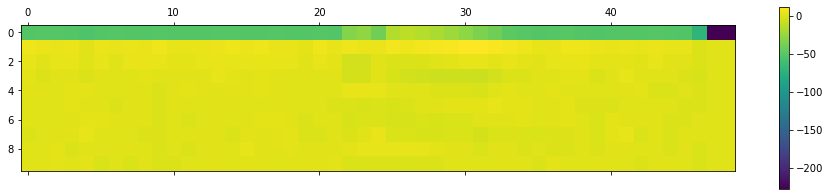

In [18]:
# Plot the MFCC features
plt.matshow(mfcc_feat_py)
plt.colorbar()
plt.show()

In [19]:
# Quantize MFCC features
quant_mfcc_feat = quantize_input(mfcc_feat_py)

In [20]:
# Run inference on the FPGA
accel.batch_size = 1
res_acc = accel.execute(quant_mfcc_feat)

In [21]:
res_label = tf_dataset_labels[res_acc[0,0].astype(int)]
print(f"The audio file was classified as: {res_label}")

The audio file was classified as: go


In [22]:
sample_classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
for sample_class in sample_classes:
    rate, raw_signal = wav.read(f"{audio_samples_folder}audio_sample_{sample_class}.wav")
    mfcc_feat_py = py_speech_preprocessing(raw_signal, rate)
    quant_mfcc_feat = quantize_input(mfcc_feat_py)
    accel.batch_size = 1
    res_acc = accel.execute(quant_mfcc_feat)
    res_label = tf_dataset_labels[res_acc[0,0].astype(int)]
    print(f"The audio file for {sample_class} was classified as: {res_label}")

The audio file for down was classified as: go
The audio file for go was classified as: go
The audio file for left was classified as: yes
The audio file for no was classified as: no
The audio file for off was classified as: on
The audio file for on was classified as: on
The audio file for right was classified as: right
The audio file for stop was classified as: stop
The audio file for up was classified as: up
The audio file for yes was classified as: yes


In [23]:
# For any audio, add noise corresponding to your filter, apply the filter you designed in Lab3b
# Observer the MFCC difference and model output diffenrence (nosiy signal, denoised signal)
# ----
# YOUR CODE HERE
# ----

# Q1: Comment your ideas how to integrate the filter and the keywords classification model.
# Q2: What are the benefits of deploying the model on the FPGAs.
# Q3: Discuss how you could integrate microphone input with filter and KWS model for a real e2e KWS edge task
# Q4: (optional): Implement Q3 idea.